In [18]:
import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils
plt.rcParams['figure.figsize'] = (13, 5)

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from collections import Counter
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

In [2]:
features = pd.read_csv('data/fma_metadata/df_senzaOutliers.csv',index_col=[0], header=[0,1,2])

features

feature    chroma_stft       mfcc                                    \
statistics        mean        max                                     
number              01         01         03          04         07   
track_id                                                              
2             0.696063  28.657707  52.424423  103.289833  37.843021   
3             0.449602  29.380682  76.742714  137.245010  55.662521   
5             0.481160 -40.500740  50.373932  112.312531  29.266182   
10            0.388109  20.196968  60.412815   78.466721  21.597277   
134           0.438062 -41.723225  58.687328  125.922821  37.450359   
...                ...        ...        ...         ...        ...   
155297        0.408626   3.826046  94.208336   48.085751  26.723190   
155298        0.439034 -72.790154  81.013275  124.569000  29.571426   
155306        0.369401  -7.814734  88.024063  116.180260  29.388819   
155307        0.357939 -13.889938  62.219879   93.028778  41.311356   
155314        0.551894 -15.305521  32.737503   95.054657  25.620636   

feature                                                                ...  \
statistics                   mean           min                        ...   
number             11          02            02         04         05  ...   
track_id                                                               ...   
2           27.737400  116.696678 -1.421085e-14 -51.569004 -97.879890  ...   
3           26.740063  120.158501 -1.851665e+01 -12.548506 -87.048355  ...   
5           27.197964  132.215073 -6.228398e+01 -24.319845 -74.060310  ...   
10          24.780317  157.040085  5.151435e-14 -50.578659 -45.113949  ...   
134         36.486378  125.521309 -9.427860e-01 -90.334747 -67.671829  ...   
...               ...         ...           ...        ...        ...  ...   
155297      19.866936  163.954620 -1.776357e-14 -29.221125 -28.104187  ...   
155298      38.472843  160.770218 -7.993606e-14  -7.314378 -69.236115  ...   
155306      47.185654  177.614151  5.329071e-15 -49.451691 -70.841232  ...   
155307      33.690544  124.228142 -5.892177e+00 -50.547176 -99.119080  ...   
155314      34.402496  166.692734 -2.464827e-01 -55.172737 -55.477066  ...   

feature                          spectral_bandwidth spectral_contrast  \
statistics        std                      kurtosis               max   
number             02         04                 01                03   
track_id                                                                
2           38.569584  20.767921           3.874384         39.333603   
3           41.191982  22.025253           2.383340         42.141411   
5           39.367599  24.319347           0.895442         39.017235   
10          44.409843  14.013119           0.437628         45.410881   
134         47.266518  36.841534           0.372903         41.526760   
...               ...        ...                ...               ...   
155297      30.287067  12.060067          20.706787         40.720093   
155298      39.359367  18.604885           5.868375         39.627396   
155306      40.537926  28.671246           4.375974         40.628235   
155307      35.382370  22.123117          -0.383395         48.715477   
155314      26.786989  22.369673           0.011010         39.460281   

feature                           tonnetz metadata                              
statistics                  min       std      set         track                
number             04        02        01   subset     genre_top genre_top_Cat  
track_id                                                                        
2           31.513493  2.296826  0.019809    small       Hip-Hop             7  
3           31.473713  0.652681  0.026316   medium       Hip-Hop             7  
5           33.707951  2.314010  0.025550    small       Hip-Hop             7  
10          28.711344  4.415900  0.021413    small           Pop            12  
134         32.2243

In [3]:
attributes = [col for col in features.columns if (col != ('metadata','track','genre_top') and 
                                                  col != ('metadata','set','subset')  and
                                                 col != ('metadata','track','genre_top_Cat'))] 

X = features[attributes].values
y = features[('metadata','track','genre_top_Cat')]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)


In [8]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [9]:

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
clf1 = GridSearchCV(GaussianNB(), 
                 param_grid=params_NB, 
                 cv=StratifiedKFold(5), 
                 scoring='f1_macro') 

clf1 = clf1.fit(X_train, y_train)
report(clf1.cv_results_, n_top=5)





Model with rank: 1
Mean validation score: 0.286 (std: 0.012)
Parameters: {'var_smoothing': 1e-09}

Model with rank: 2
Mean validation score: 0.286 (std: 0.011)
Parameters: {'var_smoothing': 1.2328467394420635e-09}

Model with rank: 3
Mean validation score: 0.285 (std: 0.010)
Parameters: {'var_smoothing': 1.519911082952933e-09}

Model with rank: 4
Mean validation score: 0.284 (std: 0.011)
Parameters: {'var_smoothing': 1.873817422860387e-09}

Model with rank: 5
Mean validation score: 0.284 (std: 0.010)
Parameters: {'var_smoothing': 2.310129700083158e-09}



In [10]:
clf1 = GaussianNB()
clf1 = clf1.fit(X_train, y_train)

In [16]:
y_pred_tr = clf1.predict(X_train)
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average='macro'))
print('Val Recall %s' % recall_score(y_train, y_pred_tr,average='macro'))
print('Val Precision %s' % precision_score(y_train, y_pred_tr,average='macro'))

print(classification_report(y_train, y_pred_tr))

confusion_matrix(y_train, y_pred_tr)

Train Accuracy 0.47327715571972756
Train F1-score 0.2923674526335309
Val Recall 0.32795533586774683
Val Precision 0.29981306087833104
              precision    recall  f1-score   support

           0       0.08      0.02      0.03        52
           1       0.42      0.71      0.53       433
           2       0.07      0.10      0.08       125
           3       0.00      0.00      0.00        15
           4       0.59      0.41      0.48      4367
           5       0.33      0.09      0.14      1507
           6       0.39      0.50      0.44      1061
           7       0.31      0.64      0.42      1538
           8       0.28      0.25      0.26       926
           9       0.32      0.13      0.19       709
          10       0.12      0.12      0.12       267
          11       0.80      0.94      0.86       351
          12       0.16      0.03      0.05       827
          13       0.59      0.74      0.66      4959
          14       0.05      0.06      0.06       108
 

array([[   1,    0,    1,    0,    4,    1,   13,   15,    1,    1,    1,
           0,    0,   14,    0,    0],
       [   0,  307,    0,    0,    8,    5,   29,    3,   30,    4,   22,
           9,    1,   14,    0,    1],
       [   1,    0,   12,    0,    4,    0,   22,   23,    0,    2,    0,
           0,    0,   60,    0,    1],
       [   0,    3,    0,    0,    3,    0,    1,    5,    2,    0,    0,
           0,    0,    1,    0,    0],
       [   0,   59,   12,    0, 1785,  108,  106, 1083,  151,   54,   53,
           4,   34,  815,   96,    7],
       [   2,   91,    8,    0,  308,  138,   87,  150,  157,   38,   36,
          34,   12,  410,    6,   30],
       [   1,   21,   18,    0,   53,   18,  533,  106,   59,   11,   20,
           5,   12,  198,    0,    6],
       [   0,    1,    9,    0,  189,    3,   24,  982,   11,   10,    8,
           0,    9,  258,   11,   23],
       [   0,  167,    0,    1,   99,   32,   91,   34,  227,   16,   56,
          12,    9,  1

In [17]:
y_pred = clf1.predict(X_test)

print('Val Accuracy %0.4f' % accuracy_score(y_test, y_pred))


print('Train F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print('Val Recall %s' % recall_score(y_test, y_pred,average='macro'))
print('Val Precision %s' % precision_score(y_test, y_pred,average='macro'))

print(classification_report(y_test, y_pred))

confusion_matrix(y_test, y_pred)

Val Accuracy 0.4732
Train F1-score 0.28917974442420835
Val Recall 0.31602482928235337
Val Precision 0.2992087366581737
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.46      0.73      0.56       185
           2       0.10      0.11      0.11        53
           3       0.00      0.00      0.00         6
           4       0.58      0.41      0.48      1871
           5       0.36      0.11      0.17       646
           6       0.37      0.46      0.41       455
           7       0.31      0.67      0.42       659
           8       0.26      0.21      0.23       397
           9       0.33      0.12      0.18       304
          10       0.11      0.11      0.11       115
          11       0.83      0.90      0.87       151
          12       0.14      0.02      0.04       355
          13       0.59      0.75      0.66      2126
          14       0.04      0.04      0.04        46
          15    

C:\Users\Federico\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Federico\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[   0,    0,    0,    0,    1,    1,    3,    4,    1,    0,    3,
           0,    1,    8,    0,    0],
       [   1,  135,    0,    0,    4,    2,   11,    1,    9,    0,    9,
           1,    1,    6,    0,    5],
       [   1,    0,    6,    0,    1,    2,   11,    7,    0,    0,    0,
           0,    0,   25,    0,    0],
       [   0,    1,    0,    0,    1,    0,    0,    4,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   2,   20,    5,    0,  769,   40,   38,  521,   61,   22,   20,
           3,   10,  325,   33,    2],
       [   0,   29,    1,    0,  158,   72,   43,   56,   63,    9,   17,
          11,    6,  173,    0,    8],
       [   1,   11,   10,    0,   21,   11,  211,   31,   30,    4,    9,
           3,    5,  105,    0,    3],
       [   0,    1,    7,    0,   93,    0,    4,  444,    0,    9,    0,
           0,    5,   85,    7,    4],
       [   0,   58,    0,    0,   56,   20,   50,   11,   82,    1,   30,
           4,    4,   

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 1.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[   0    0    0    0    1    1    3    4    1    0    3    0    1    8
     0    0]
 [   1  135    0    0    4    2   11    1    9    0    9    1    1    6
     0    5]
 [   1    0    6    0    1    2   11    7    0    0    0    0    0   25
     0    0]
 [   0    1    0    0    1    0    0    4    0    0    0    0    0    0
     0    0]
 [   2   20    5    0  769   40   38  521   61   22   20    3   10  325
    33    2]
 [   0   29    1    0  158   72   43   56   63    9   17   11    6  173
     0    8]
 [   1   11   10    0   21   11  211   31   30    4    9    3    5  105
     0    3]
 [   0    1    7    0   93    0    4  444    0    9    0    0    5   85
     7    4]
 [   0   58    0    0   56   20   50   11   82    1   30    4    4   79
     2    0]
 [   2    7    9    0   37   12   37   62    4   37    3    1    1   88
     2    2]
 [   1    6    1    0   15    2   23   12    6    3   13    1    2   30
     0    0]
 [   0    5    0    0    

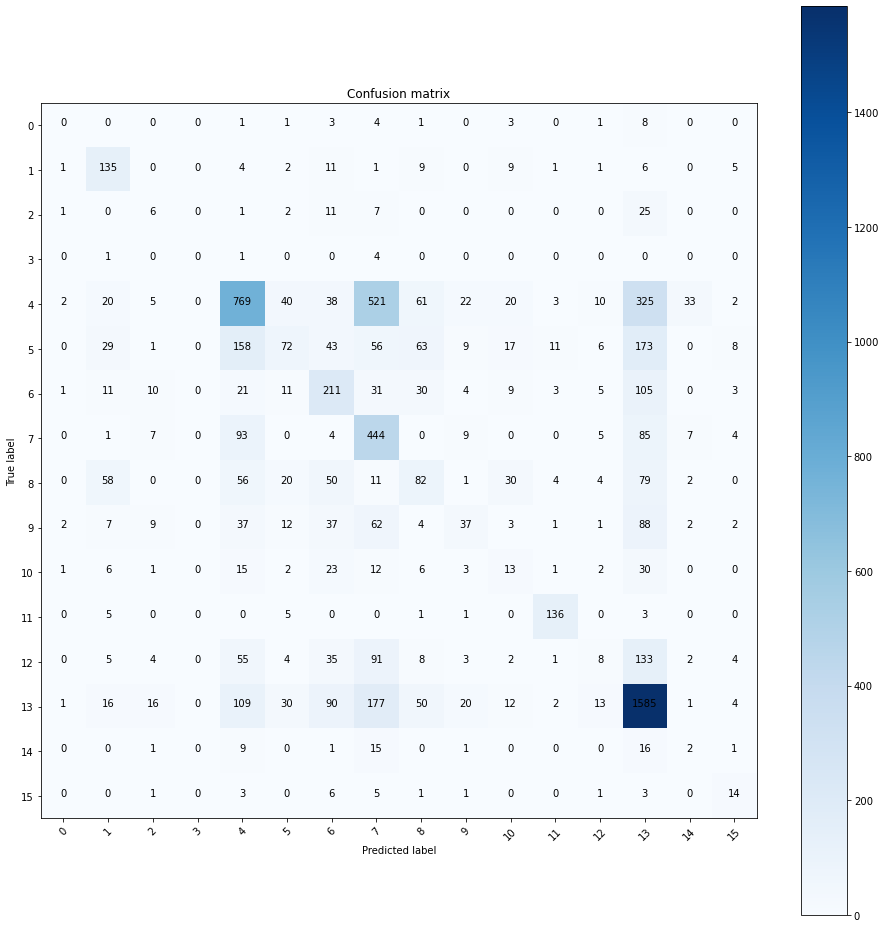

In [14]:
plt.rcParams['figure.figsize'] = (13, 13)

cm1=confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm1, classes=clf1.classes_,
                      title='Confusion matrix')



plt.show()

In [19]:
# Binarize the output
y_testRoc = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15])
n_classes = y_testRoc.shape[1]
y_score= clf1.predict_proba(X_test)


In [20]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_testRoc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_testRoc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<ipython-input-21-a04f421d14f6>:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


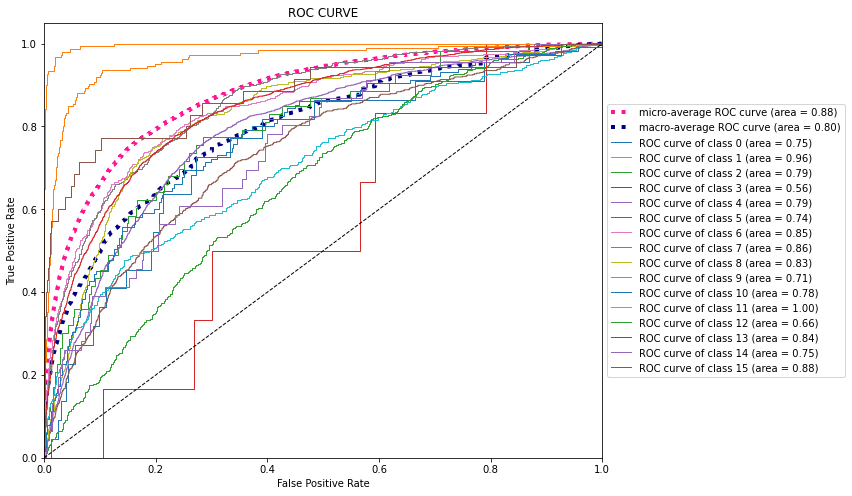

In [21]:
lw = 1
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')

# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()